In [1]:
import os
import streamlit as st   #For the User Interface
st.set_page_config(page_title="Youtube Chatbot", page_icon="💬", layout="centered")
from langchain_huggingface import HuggingFaceEmbeddings # Load the  embedding model from huggingface
from langchain_chroma import Chroma #Vectorstore to store the embedded vectors
from langchain_community.document_loaders.csv_loader import CSVLoader #To load the csv file (data containing companys faq)
from langchain_community.tools import DuckDuckGoSearchRun #Search user queries Online
from langchain_groq import ChatGroq  #Load the open source Groq Models
from langgraph.graph import StateGraph, START, END #Define the State for langgraph
from langgraph.prebuilt import ToolNode,tools_condition #specialized node designed to execute tools within our workflow.
from langchain_core.messages import AnyMessage #Human message or Ai Message
from langgraph.graph.message import add_messages  ## Reducers in Langgraph ,i.e append the messages instead of replace
from typing_extensions import Annotated,TypedDict #Annotated for labelling and TypeDict to maintain graph state 
from langchain_core.tools import tool
from langchain_core.messages import trim_messages # Trim the message and keep past 2 conversation
from langgraph.checkpoint.memory import MemorySaver #Implement langgraph memory
from langchain_core.messages import HumanMessage, AIMessage
from youtube_transcript_api import YouTubeTranscriptApi
from langchain.chains.query_constructor.schema import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from collections import defaultdict
from datetime import timedelta
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate ,PromptTemplate
from langchain_core.output_parsers import StrOutputParser

from dotenv import load_dotenv  #Load environemnt variables from .env
load_dotenv()
# Create a Unique Id for each user conversation
import uuid

2025-08-06 23:29:25.620 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [2]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2") #Load the hf Embedding model
# llm = ChatOpenAI(model='gpt-4o-mini')
llm = ChatGroq(temperature=0.4, model_name='Llama-3.3-70b-versatile',max_tokens=3000) #Initialize the llm
search = DuckDuckGoSearchRun()  #Duckducksearch

c:\Users\Prabal Kuinkel\Desktop\AI_Projects\Youtube-Conversational_AI\youtube_conver_ai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
youtube_url = "https://www.youtube.com/watch?v=LPze5QLvb2M"

if youtube_url:
    video_id = youtube_url.split("v=")[-1].split("&")[0]
else:
    video_id = "default"

persist_dir = f"chroma_index/{video_id}"  # Use unique folder per video
vectorstore = Chroma(collection_name=video_id, embedding_function=embedding_model)

docs = []
documents = []

if youtube_url:
    try:
        ytt_api = YouTubeTranscriptApi()
        try:
            docs = ytt_api.fetch(video_id, languages=["en"])
            # print(docs)
        except Exception as e:
            print("Transcript not found for this video.")

        # Step 1: Group snippets by minute
        minute_chunks = defaultdict(list)
        minute_starts = {}

        for snippet in docs:
            minute = int(snippet.start // 60)
            minute_chunks[minute].append(snippet.text)

            # Save the earliest start time per minute
            if minute not in minute_starts:
                minute_starts[minute] = snippet.start

        # Step 2: Create LangChain Document objects with HH:MM:SS timestamps
        for minute in sorted(minute_chunks.keys()):
            content = " ".join(minute_chunks[minute])

            # Format start time to HH:MM:SS
            seconds = int(minute_starts[minute])
            timestamp = str(timedelta(seconds=seconds))

            metadata = {
                "minute": minute,
                "start_timestamp": timestamp
            }

            doc = Document(page_content=content, metadata=metadata)
            documents.append(doc)

        # print(documents)
        vectorstore.add_documents(documents)

    except Exception as e:
        pass


c:\Users\Prabal Kuinkel\Desktop\AI_Projects\Youtube-Conversational_AI\youtube_conver_ai\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [4]:
metadata_field_info = [
        AttributeInfo(
            name="start_timestamp",
            description="The starting second of the video chunk (in format of : 'HH:MM:SS)",
            type="integer"  # Changed from string to integer
        ),
        AttributeInfo(
            name="minute",
            description="Time of the video played",
            type="integer"
        )]
        # First get the base retriever from your vectorstore with increased k
base_vectorstore_retriever = vectorstore.as_retriever(
            search_type = "mmr",
            search_kwargs={"k": 8 , "lambda_mult":0.3} 
        )
document_content_description = "Transcript of a youtube video"
retriever = SelfQueryRetriever.from_llm(
            llm,
            vectorstore,
            document_content_description,
            metadata_field_info,
            base_retriever = base_vectorstore_retriever,
            verbose=True,
            # search_kwargs={"k": 8} 
        )

In [5]:
# retriever.invoke("Who won the match")

## Define the router Pydantic basemodel

In [6]:
from pydantic import BaseModel,Field
from typing import Literal 

class Routequery(BaseModel):
    decision : Literal["generate_audio","stop"] = Field(...,description="Given a user question choose to route to `summarize_qa` or `stop`")

## Langgraph States

In [22]:
from typing_extensions import TypedDict
from typing import List
from langchain_core.messages import BaseMessage


class State(TypedDict):
    """Represents the state of our graph
    
    Attribute:

    messages : All the messages in our graph , including AIMessage , HumanMessage .
   
    """

    messages: Annotated[list[BaseMessage], add_messages] #List of messages appended

## Node-1 : (Routing node)

In [23]:
from langchain_core.prompts import ChatPromptTemplate
system_msg = """You are an expert at routing a user query.

If the user query is about generating audio or speech from the content, return "generate_audio".
If it's about providing summary or answering specific content from the video transcript, return "stop".
"""
template_route = ChatPromptTemplate([
    ("system", system_msg),
    ("human", "{question}")
])
structured_llm_router = llm.with_structured_output(Routequery)

chain_router = template_route | structured_llm_router

# Router function
def route_query(state: State) -> dict:
    """Route question to `generate_audio` or `stop` .
    
    Arguments:
        state(dict) : Current graph state .

    Returns:
        state(dict) : Updated graph state by adding the intent of the user .
    """

    user_msg = next(msg for msg in reversed(state["messages"]) if isinstance(msg, HumanMessage))
    intent = chain_router.invoke({"question": user_msg.content})
    # if intent.decision =="generate_audio":
    #     return "generate_audio"
    # else:
    #     return "stop"
    return {"decision": intent.decision}
    
    

    

## Node 2 : (Question Answering and Summarize Node)

In [ ]:
def summarize_qa(state: State) -> State:
    """Generates either a summary or a dialogue depending on the user query."""

    system_msg = """You're a helpful assistant that summarizes YouTube video transcripts in a way that feels natural and engaging.

Your tasks:
- If the user asks about the summary of video , video's content, query about specific time stamp in the video, provide a clear, friendly summary, as if you're casually explaining it to someone who hasn’t seen the video. Arrange the content in chronological order as you will also have the time stamp .
- If the user asks for **audio or speech**, generate a natural-sounding conversation between two people (Person A and Person B) discussing the video. Make it feel like a real exchange — include reactions, questions, and follow-ups. Start the communication with 2 people discussing the agenda of the video.

Guidelines:
- Always use only the transcript for answers.
- Keep your tone human, not robotic or overly formal.
"""


    # Get all messages (including history)
    messages = state["messages"]
    
    # Get last human message
    user_msg = next(msg for msg in reversed(messages) if isinstance(msg, HumanMessage))
    
    # Get transcript context
    result = retriever.invoke(user_msg.content)
    context_docs = []
    for doc in result:
        metadata = doc.metadata
        content = doc.page_content
        # extract metadata variables
        minute = metadata.get("minute")
        start_timestamp = metadata.get("start_timestamp")
        # append context with metadata + content
        context_docs.append(f"Start Time: {start_timestamp}, Minute: {minute}\n{content}")

    context = "\n\n".join(context_docs)
    # print(context)
    
    # Prepare conversation history for context
    conversation_history = "\n".join(
        f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content}"
        for msg in messages[:-1]  # Exclude current message
    )

    template_generate_response = ChatPromptTemplate.from_messages([
        ("system", system_msg),
        ("human", f"Conversation History:\n{conversation_history}\n\n"
                 f"Current Question: {user_msg.content}\n\n"
                 f"Transcript Context:\n{context}")
    ])

    chain_response = template_generate_response | llm
    response = chain_response.invoke({})  # All context is in the prompt template
    
    # Append new response to existing messages
    return {"messages": messages + [response]}

## Node 3: (Generating Audio)

In [25]:
conversation_sys_msg ="""Based on the provided conversation between 2 people, enhance these conversation and return a list in this format . Directly start with the conversation
***Expected Output*** :
[
"Hey how are you ?" ,
"I am fine , what about you " ,
".........",
...
]
"""

def generate_audio(state: State) -> State:
    """ Generate a audio version of the youtube video .env

    Argument:
        state(dict) : The Current graph state .
    
    Returns :
        state(dict) : The updated graph state by appending the Conversation text .
    """
    conversation_messages = state['messages'][-1].content
    create_conversation = ChatPromptTemplate([
    ("system",conversation_sys_msg),
    ("human" , "{conversation_messages}")])

    chain = create_conversation | llm
    response = chain.invoke({"conversation_messages":conversation_messages})
    # print(response)


    return {"messages":[response]}

## Adding nodes and edged (connecting nodes)

In [26]:
from langgraph.graph import END,START,StateGraph
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
workflow = StateGraph(State)

# Add nodes
workflow.add_node("summarize_qa", summarize_qa)
workflow.add_node("route_query", route_query)
workflow.add_node("generate_audio", generate_audio)

# Add edges
workflow.set_entry_point("summarize_qa")
workflow.add_edge("summarize_qa", "route_query")
workflow.add_conditional_edges(
    "route_query", 
    lambda state: state.get("decision","stop"),
    {
        "generate_audio": "generate_audio",
        "stop": END
    }
)

# workflow.add_conditional_edges(
#     "route_query",  # this is the node name
#     path=chain_router,  # this is the LLM Runnable used for routing
#     path_map={
#         "generate_audio": "generate_audio",
#         "end": END
#     }
# )

workflow.add_edge("generate_audio", END)

app = workflow.compile(checkpointer=checkpointer)


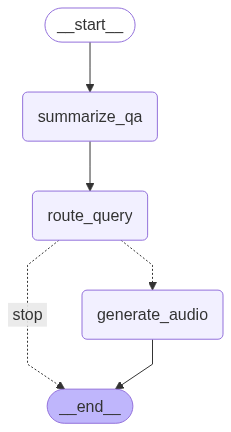

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
# Create a Unique Id for each user conversation
import uuid
thread_id = uuid.uuid4()
print(thread_id)
config = {"configurable": {"thread_id": thread_id}}

e76555aa-132a-42da-834b-c148e08287c1


In [32]:
from langchain_core.messages import HumanMessage

# result = app.invoke({
#     'messages': [HumanMessage(content='can you provide me audio ?')]
# }, config=config)

for message_chunk , metadata in app.stream({
    'messages': [HumanMessage(content='what is this video about ?')]
}, config=config,stream_mode="messages"
):
    if message_chunk.content:
        print(message_chunk.content ,end ="",flush=True)

```json
{
    "query": "",
    "filter": "NO_FILTER"
}
```

c:\Users\Prabal Kuinkel\Desktop\AI_Projects\Youtube-Conversational_AI\youtube_conver_ai\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


So, you want to know what this video is about? Well, from what I've gathered, it's about the Royal Massacre, also known as the Darbar massacre, which took place at the Narayanhiti Palace in Nepal. The video seems to be discussing the events leading up to the massacre and the investigation that followed.

It starts by setting the scene, describing the palace and the buildings where the massacre took place, including the billiard hall where Crown Prince Dipendra was playing snooker before the incident. The video then delves into the details of what happened on that night, including the prince's actions and the subsequent investigation.

The video also touches on the report submitted by the Probe Committee, which is 139 pages long, and discusses the findings and allegations made against Crown Prince Dipendra. It seems that the video is trying to provide a detailed account of the events and separate fact from fiction, as there are some discrepancies and baseless allegations surrounding the